In [1]:
import numpy as np
import PIL
from PIL import Image, ImageOps
from typing import Tuple
from termcolor import colored
import matplotlib.pyplot as plt
import cv2
from scipy.signal import convolve2d

In [65]:
class ISTA(object):
    def __init__(self, A: np.ndarray, b: np.ndarray, lam: np.ndarray, 
                 eps: float = 1e-2, n: int = 10, **kwargs):
    
        self.x = np.zeros(A.shape[1])
        self.A = A
        self.b = b
        self.lam = lam
        self.eps = eps
        self._max_n_iter = n
        self.t = kwargs['t'] if 't' in kwargs else self._compute_step_size()
        self.obj = [self.objective()]
        
        print(colored(f'{self.__class__.__name__} was initilised', 'green', attrs=['bold']))
        print(colored('\tlam:', 'blue', attrs=['bold']), self.lam, end='\t')
        print(colored('\tt:', 'blue', attrs=['bold']), self.t, end='\t')
        print(colored('\teps:', 'blue', attrs=['bold']), self.eps, end='\t')
        print(colored('\tmax_n_iter:', 'blue', attrs=['bold']), self._max_n_iter)
        
        
    def _compute_step_size(self) -> float:
#         L = np.linalg.norm(A.T @ A, ord=2)
#         return 1 / L
        sigma_min = self._estimate_sigma_min()
        sigma_max = self._estimate_sigma_max()
        
        return 2 / (sigma_min + sigma_max)
        
    def _compute_inside(self) -> np.ndarray:
        return self.x - 2 * self.t * self.A.T @ (self.A @ self.x - self.b)
        
    def _iteration(self):
        z = self._compute_inside()
        x_next = self._shrinkage_operator(alpha=self.lam*self.t, x=z)
        return x_next
        
    def _stop_criterion(self, x_next, logs: bool):
        d = np.linalg.norm(self.A.T @ (self.A @ self.x - self.b))
#         d = np.linalg.norm(self.x - x_next)
        self._stop_criterion_value = d
        if logs:
            print(colored(f'stop criterion value:', 'blue', attrs=['bold']), d)
        return d < self.eps
    
    def iterate(self, logs: bool = True) -> np.ndarray:
        
        x_next = self._iteration()
        self.obj.append(self.objective())
        i = 0
        if logs: print(colored('iter: ', 'grey', attrs=['bold']), i, end='\t')
        
        while not self._stop_criterion(x_next=x_next, logs=logs):
            i += 1
            
            if i > self._max_n_iter:
                print(colored('Early stopping', 'red', attrs=['bold']))
                break
                
            self.x = x_next.copy()
            x_next = self._iteration()
            self.obj.append(self.objective())
            if logs: print(colored('iter: ', 'grey', attrs=['bold']), i, end='\t')
            
            
            
        print(colored('Done!', 'green', attrs=['bold']))
    
    def _relu(self, x: np.ndarray) -> np.ndarray:
        x[x < 0] = 0
        return x
    
    def _shrinkage_operator(self, alpha: float, x: np.ndarray) -> np.ndarray:
        y = self._relu(np.abs(x) - alpha) * np.sign(x)
        return y
    
    
    def _estimate_sigma_max(self) -> float:
        A = self.A.T @ self.A
        upper_bounds = np.zeros(A.shape[0])
        for i in range(len(upper_bounds)):
            c = A[i, i]
            r = np.abs(A[i, :]).sum() - np.abs(A[i, i])
            upper_bounds[i] = c + r
            
        return np.abs(upper_bounds.max())
    
    def _estimate_sigma_min(self) -> float:
        A = self.A.T @ self.A
        lower_bounds = np.zeros(A.shape[0])
        for i in range(len(lower_bounds)):
            c = A[i, i]
            r = np.abs(A[i, :]).sum() - np.abs(A[i, i])
            lower_bounds[i] = c - r
            
        return np.abs(lower_bounds.max())
    
    
    def objective(self):
        return np.linalg.norm(self.A @ self.x - self.b) ** 2 + self.lam * np.linalg.norm(self.x, ord=1)
        


In [66]:
rng = np.random.RandomState(42)
m, n = 15, 20

# random matrix A
A = rng.randn(m, n)  

x0 = rng.rand(n)
x0[x0 < 0.9] = 0
print('original x: {}'.format(x0))
b = np.dot(A, x0)

original x: [0.         0.         0.         0.         0.99050514 0.
 0.         0.         0.         0.93075733 0.         0.
 0.         0.         0.         0.90255291 0.         0.
 0.         0.        ]


In [67]:
b.shape, A.shape, x0.shape

((15,), (15, 20), (20,))

In [87]:
model = ISTA(lam=0.5, A=A, b=b, n=3*1e+3, eps=1e-2, t=1e-3)

ISTA was initilised
	lam: 0.5		t: 0.001		eps: 0.01		max_n_iter: 3000.0


In [88]:
model.iterate(logs=False)

Early stopping
Done!


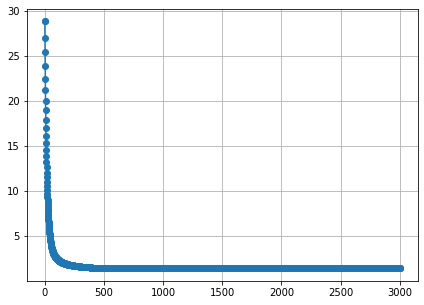

In [89]:
plt.figure(figsize=(7, 5))
plt.plot(model.obj, '-o')
plt.grid()
plt.show()

In [90]:
model.x

array([-0.        ,  0.        ,  0.        , -0.        ,  0.96307552,
        0.        ,  0.        ,  0.        ,  0.        ,  0.91099608,
        0.        , -0.        , -0.        ,  0.        , -0.        ,
        0.8784868 , -0.        ,  0.        ,  0.        , -0.        ])

In [91]:
x0

array([0.        , 0.        , 0.        , 0.        , 0.99050514,
       0.        , 0.        , 0.        , 0.        , 0.93075733,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.90255291, 0.        , 0.        , 0.        , 0.        ])

In [113]:
from skimage.restoration import wiener

img_origin = ImageOps.grayscale(Image.open('./Sun_Hays_SR_groundtruth/balcony_interior_sun_bammhtthmkjntkqh.jpg'))
img_origin = np.array(img_origin) / 255

blured = convolve2d(img_origin, kernel_np)
blured /= blured.max()

deconvolved_img = wiener(blured, kernel_np, 1100)

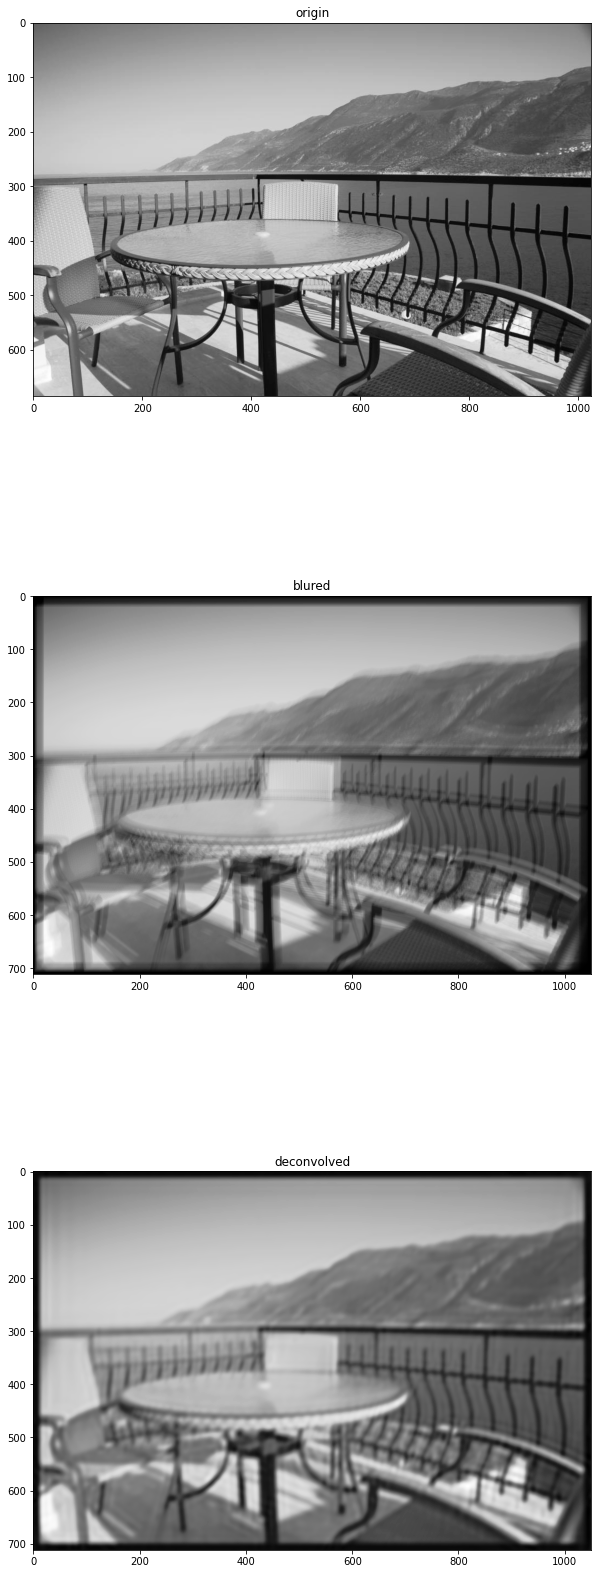

In [114]:
fig, axs = plt.subplots(3, 1, figsize=(10, 30))

axs[0].imshow(img_origin, cmap='Greys_r')
axs[0].set_title('origin')
axs[1].imshow(blured, cmap='Greys_r')
axs[1].set_title('blured')
axs[2].imshow(deconvolved_img, cmap='Greys_r')
axs[2].set_title('deconvolved')
plt.show()

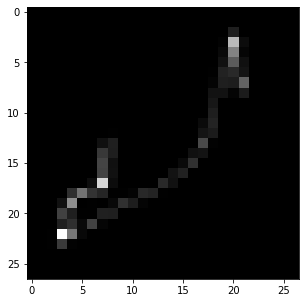

In [115]:
kernel = Image.open('kernels/kernel4_groundtruth_kernel.png')
plt.figure(figsize=(5, 5))
plt.imshow(kernel, cmap='Greys_r')
plt.show()